In [1]:
import pandas as pd
import numpy as np
from collections import defaultdict, Counter

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data_utils
from torch.nn.utils import clip_grad_norm_
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence
from tqdm import tqdm
import shutil
from utils import count_parameters, accuracy, pooling
from config import NUM_EPOCHS, CV_DATA

import pyro
import pyro.distributions as dist
from pyro.distributions import Normal, Categorical
from pyro.infer import SVI, Trace_ELBO, TraceEnum_ELBO, config_enumerate
from pyro.optim import Adam, ClippedAdam, SGD

from bayesian_vae import *

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
plt.style.use('ggplot')

In [4]:
%matplotlib inline

In [5]:
state = torch.load('nn_state.pth.tar')

In [6]:
mdl = VAE()

In [7]:
mdl.load_state_dict(state['state_dict'])

<All keys matched successfully>

In [8]:
mdl.eval()

VAE(
  (encoder): Encoder(
    (rnn_enc): RNNEncoder(
      (rnn): GRU(1, 12, num_layers=2, bias=False)
      (fc): Sequential(
        (0): Linear(in_features=24, out_features=40, bias=True)
        (1): Tanh()
        (2): Linear(in_features=40, out_features=20, bias=True)
      )
    )
    (fc_scale): Linear(in_features=20, out_features=20, bias=True)
    (fc_loc): Linear(in_features=20, out_features=20, bias=True)
  )
  (decoder): Decoder(
    (decoder): Sequential(
      (0): Linear(in_features=20, out_features=128, bias=True)
    )
  )
)

In [9]:
cv_loader = torch.load('vae_cv_loader.pt')

In [10]:
cv_xs = next(iter(cv_loader))

In [11]:
x = cv_xs[5]
x = x.unsqueeze(0)

In [12]:
with torch.no_grad():
    res = mdl.reconstruct(x)

In [13]:
res = res.detach().cpu().numpy().squeeze()

In [14]:
x = x.detach().cpu().numpy().reshape(-1)

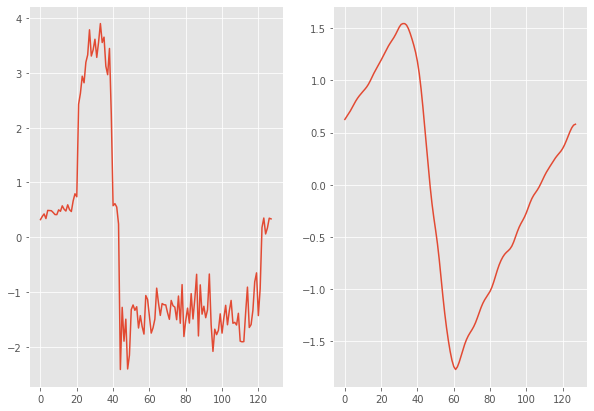

In [15]:
f, axes = plt.subplots(1, 2, figsize=(10,7))
sns.lineplot(x=np.arange(len(res)), y=res, ax=axes[0])
sns.lineplot(x=np.arange(len(x)), y=x, ax=axes[1])

### Latent Representation

In [16]:
cv_loader = torch.load('cv_loader.pt')

In [17]:
x,y = next(iter(cv_loader))

In [18]:
y

tensor([1, 0, 0, 2, 1, 2, 0, 1, 2, 2, 1, 2, 1, 0, 2, 1, 1, 2, 1, 0, 0, 1, 1, 0,
        1, 2, 0, 2, 0, 0, 1, 2, 2, 0, 0, 2, 1, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 1,
        2, 0, 2, 1, 1, 1, 1, 0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 1, 0,
        2, 0, 2, 1, 0, 0, 2, 2, 2, 2, 1, 0, 2, 2, 2, 0, 1, 1, 1, 0, 0, 2, 0, 1,
        1, 0, 1, 2, 1, 1, 1, 0, 0, 1, 0, 0, 2, 2, 1, 2, 1, 1, 1, 1, 0, 0, 1, 1,
        1, 0, 1, 0, 2, 2, 0, 0, 0, 1, 0, 2, 1, 0, 1, 1, 2, 1, 0, 0, 2, 1, 0, 0,
        0, 1, 1, 0, 0, 0, 0, 1, 2, 1, 0, 1, 1, 0, 0, 1, 0, 2, 1, 2, 0, 2, 2, 1,
        2, 2, 2, 2, 0, 1, 0, 0, 2, 2, 0, 2, 1, 0, 1, 1, 2, 0, 2, 0, 2, 2, 0, 2,
        2, 0, 2, 2, 1, 1, 2, 2])

In [26]:
zs = []
ys = []
for i, data in enumerate(cv_loader):
    print(i)
    x, y = data
    ys.append(y)
    out = mdl.encoder(x)[0]
#     out = torch.tanh(out)
    zs.append(out)
# zs = [x for a in zs for a in x]

0
1


In [27]:
hiddens = torch.cat(zs).detach().numpy()

In [28]:
labels = torch.cat(ys).detach().numpy()

### Dim reduction / TSNE

In [29]:
from sklearn.manifold import TSNE

In [30]:
tsne = TSNE()

In [31]:
reduced = tsne.fit_transform(hiddens)

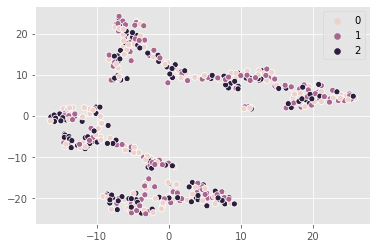

In [32]:
sns.scatterplot(x = reduced[:, 0], y = reduced[:, 1], hue=labels)